# Assignment 2
**Samuel Sheehy (Student ID 18143565)**

**Techniques of High Performance Computing (PHAS0102)**

**MSc Scientific Computing, University College London**, **2019-2020**

This Jupyter Notebook is submitted as completion of the 2nd Assignment for the UCL course cited above.

## Setup
This cell imports the libraries and defines the helper functions
that will be used for the entirety of the assignment.

In [1]:
# Entire libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pyopencl as cl


# Specific Functions
from scipy.sparse import find, random, csr_matrix
from scipy.sparse.linalg import LinearOperator, cg


# User-define helper functions
class Timer:
    """
    A simple timer class to measure the execution time
    of a function (seconds) in a ```with``` block.
    Taken from module lecture notes.
    """
    def __enter__(self):
        """
        Measure time at start.
        """
        self.start = time.time()
        return self

    def __exit__(self, *args):
        """
        Measure time at end and take difference
        from start.
        """
        self.end = time.time()
        self.interval = self.end - self.start

        
def bytesize(N, dtype_str):
    """
    Returns the number of bytes that an array of element
    size N occupies
    """
    return np.dtype(dtype_str).itemsize*N

## Question 1: OpenCL CSR matrix-vector product

### Explanation

The aim is to create a linear operator object that can operate quickly
on a vector. This speed is aquired by implementing the OpenCL library.

#### Approach:
By using SciPy's LinearOperator class as a parent, we implement a custom
method for the ```matvec``` operation which performs a matrix-vector
product.

A matrix-vector product is a series of additions and multiplications that must
be done over many different data elements: for each row, we take the dot
product of that row and the entire vector. Consequently each of these calculations
is independent of each other, which means that we can optimise the
performance of the ```matvec``` method by parellelising the algorithm according
to each row.

Within each row-vector dot-product, many similar operations must be performed.
Each corresponding element from the row and the vector must be multiplied together
and then added to the total sum of these products. We implement this in practice
by using the SIMD features of AVX2: each matrix element and vector element are loaded
into their respective ```double8``` object; these are multiplied together and
added to an intermediate sum. Once all elements have been processed, the intermediate
```double8```-type sum is reduced by addition into the final sum.

In the case where the vector-length is not a multiple of 8, the above method
applied to the vector and matrix-row until there are less than 8 pairs of elements
remaining. After which, this final group is operated on individually without the 
```double8``` datatype. These products are directly added to the final sum.

#### Validating Result:
The data used to generate the seed matrix for the OpenCL Linear Operator
is used to also create an equivalent SciPy sparse matrix ```A```. We then use the
built-in method ```A.dot(x)``` to operate ```A``` on the same vector as for
the OpenCL Linear Operator, and we then compare the results - expecting them
to be equal.

#### Measuring Performance:
For curiosity's sake, we measure the execution speed of both methods and display these as well.

### Implementation
#### Generate a Random Sparse Matrix 
Used to seed the Linear Operator and to create
an identical matrix for validation purposes. 

In [2]:
# Here we generate a random sparse matrix in the CSR format
# and save it as three distinct objects (index pointers, 
# indicies and data). This matrix will define the linear
# operator.
def generate_sparse_matrix(rows, columns, density=0.3):
    """
    Generate a random sparse matrix of shape (rows x columns)
    in CRS format and return the index pointer array, column 
    indices and data as three distinct objects as well as a
    dense copy of the matrix.
    """
    # Using numpy.sparse.random
    sparse_matrix = random(rows, columns,
                           density=density, format='csr')
    # Extract sparse matrix info and return dense copy
    return (sparse_matrix.indptr, sparse_matrix.indices,
            sparse_matrix.data), sparse_matrix.A

#### Construct the Linear Operator

In [3]:
# This cell implements an OpenCL-based Linear Operator. It defines a
# subclass which calls an OpenCL program builder. The OpenCL
# program is then linked to the matvec method of the created
# LinearOperator.
class OpenCL_LOp(LinearOperator):
    """
    Created in reference to the PyLops Linear Operator tutorial.
    """
    def __init__(self, rows, columns, sparse_matrix, data_type=np.float64):
        """
        Set up the subclass with the shape of the matrix, the sparse matrix,
        and its data type. This initialiser sets the key parameters for
        the definition of a subclass of the LinearOperator class.
        """
        # Setup parameters (required by parent class)
        self.shape = (rows, columns)
        self.dtype =  np.dtype(data_type)
        self.explicit = False
        # Store the sparse matrix
        self.indptr, self.indices, self.data = sparse_matrix
        # Create the OpenCL tool
        self.openCL_matvec = initialise_OCL_kernel(self.indptr,
            self.indices, self.data, self.shape)

    def _matvec(self, x):
        """
        Apply the initialised operator to the given vector.
        """
        return self.openCL_matvec(x)


def initialise_OCL_kernel(indptr, indicies, data, shape):
    """
    Generate an OpenCL-implemented operator to perform
    the matrix-vector product of the given sparse
    matrix on a vector x.
    """
    # Unpack shape parameter
    mat_rows, columns = shape
    # OpenCL C-Language Kernel
    # This implements the row-wise dot product
    kernel = """
        __kernel void matvec(
            __global uint *indptr,
            __global uint *indicies,
            __global double *data,
            __global double *myvector,
            __global double *result
        )
        {        
        // Get Global Identifiers i.e. the row index
        int row_index = get_global_id(0);

        // Initialise parameters
        int start = indptr[row_index];
        int end = indptr[row_index + 1];
        int k;
        double sum = 0;
        double8 data_8;
        double8 vector_8;
        double8 product_8;
        double8 subsum_8 = 0;
        int extra = (end-start) % 8; // Determine how many elements
                                     // are not able to fit into 
                                     // the double8 object
        
        // Do the dot product
        for(k=start; k < end-extra; k=k+8){
            
            // Load the data into the AVX feature
            data_8 = (double8)(data[k + 0],
                               data[k + 1],
                               data[k + 2],
                               data[k + 3],
                               data[k + 4],
                               data[k + 5],
                               data[k + 6],
                               data[k + 7]);
                            
            vector_8 = (double8)(myvector[indicies[k + 0]],
                                 myvector[indicies[k + 1]],
                                 myvector[indicies[k + 2]],
                                 myvector[indicies[k + 3]],
                                 myvector[indicies[k + 4]],
                                 myvector[indicies[k + 5]],
                                 myvector[indicies[k + 6]],
                                 myvector[indicies[k + 7]]);
        
            // Perform element-wise product and add to sum
            product_8 = data_8 * vector_8;
            subsum_8 += product_8;           
        }
        
        sum += subsum_8.s1 + subsum_8.s2
               + subsum_8.s3 + subsum_8.s4
               + subsum_8.s5 + subsum_8.s6
               + subsum_8.s7 + subsum_8.s0;
        
        // Move the counter up to the last accessed
        // element and calculate the products individually for the 
        // terms that are too few for a double8
        for(int k = end-extra; k < end; k=k+1){
            sum += data[k]*myvector[indicies[k]];
        }       
        
        // Output answer
        result[row_index] = sum;
        
        }
    """
    # Initialise the OpenCL environment
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    # Create the buffers to hold the sparse matrix data
    indptr_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=indptr)
    indicies_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=indicies)
    data_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=data)
    
    # Create the buffer to hold the vector data
    vector_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(columns, 'double'))
# Mapping Goes Here -->

    
    # Create buffer to hold the result
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, size=bytesize(mat_rows, 'double'))

# MAPPING
#     mapped_result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
#                                       0, mat_rows, np.double) 

    
    # Build the Kernel
    prg = cl.Program(ctx, kernel)
    prg.build()
    matvec_kernel = prg.matvec
    
    # Define what to be executed when matvec is called
    def exec_kernel(x):
        mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
            queue, vector_buffer, cl.map_flags.WRITE, 0, columns, np.dtype('double'))
        linking_event.wait()
        
        # Rewrite vector buffer
        with mapped_vector_buffer.base:
            mapped_vector_buffer[:] = x

        # Run the kernel
        matvec_kernel(
            # Workspace parameters
            queue, (mat_rows, ), (1, ),
            # Buffers
            indptr_buffer, indicies_buffer, data_buffer,
            vector_buffer, 
            result_buffer
        )
        
        mapped_result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                      0, mat_rows, np.double)
        with mapped_result.base:
            fetched_result = mapped_result
        
        return fetched_result
    # Pass the kernel executor to the class
    return exec_kernel

### Q1 DEMO: Validate Results & Measure Performance

In [4]:
# Set the Matrix Size
N = 50
rows = N
columns = N

# Execute matrix generation and aquire it in 
# both sparse and 'dense' format (for testing).
(A_sparse_matrix), A_copy = generate_sparse_matrix(rows, columns)

# Generate the Linear Operator from the values of A
mylop = OpenCL_LOp(rows, columns, A_sparse_matrix)

# Create a dummy vector of compatible size with A
x = np.ones(columns)

# Measure execution time
print('\nFor N=%i:\n' % N)
with Timer() as t:
    control_result = A_copy.dot(x)
print(' - Numpy execution time:        %5.5f ms'%(t.interval*1000))

with Timer() as t:
    cl_result = mylop.matvec(x)
print(' - OpenCL L.Op. execution time: %5.5f ms'%(t.interval*1000))


# print(control)
# print(myres)
# Measure difference between matrices
diff = np.linalg.norm(control_result - cl_result)
if np.allclose(control_result, cl_result):
    print('\nBoth matricies agree. Normed difference: %g' % diff)
else:
    
    print('\nSOMETHING WENT WRONG.\nMATRICES DIFFERENT BY NORM VALUE: %g' % diff)


For N=50:

 - Numpy execution time:        0.08893 ms
 - OpenCL L.Op. execution time: 0.65041 ms

Both matricies agree. Normed difference: 7.16072e-15


In [5]:
# %timeit A_copy.dot(x)

1.38 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [6]:
# %timeit mylop.matvec(x)

181 µs ± 46.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Question 2: Solving a Poisson Problem with OpenCL

### Explanation
#### Stating the Problem:
Consider a unit square in the $(x, y)$ plane whose interior points are
associated a value that satisfy the equation: $$ -\nabla^2u = f $$
where $u(x, y)$ describes the scalar value associated with the point
$(x, y)$. For this problem, $f = 1$, and every point on boundaries of the
unit square is defined to be 0.

The aim is to construct a Linear Operator that can help numerically estimate
the value $-\nabla u(x, y)$ using a 5-point stencil finite difference approximation:

The space within the square is discretized into $M \times M$ points, such that
the value $u_{i,j}$ approximates the point in continuous space
$u\left(\frac{i}{1+M}, \frac{j}{1+M}\right)$. We can estimate thus estimate the operator
as follows:

$$
-\nabla^2u \approx \frac{4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j+1} - u_{i,j+1}}{h^2}
$$


This Linear Operator is then passed to SciPy's CG solver that performs
an iterative method to approximate the numerical solution of the problem.

#### Approach:
The first step is to flatten the 2D space into a 1D one. This is done 
in row-order such that points in the same row are consecutive. The estimation of
$-\nabla^2u$ at one point is independent of the other estimations. This means
that the operations of the linear operator can be parallelised row-wise.

After flattening, each point $u'_{ij}$ is now designated by $u_k$ where $i$ and $j$
can be retrieved from the following relationships:

$$ i = k\backslash M $$
$$ j = k \% M$$

Where $\backslash$ is the euclidean dividor and $\%$ is the modulo operator.

Only the interior points of the matrix are considered. Because the boundary 
conditions are known to be 0, this allows for a simplification of the algorithm.
The estimate can then be rewritten in the following way:

$$ 
-\nabla^2u_k = \frac{4u_{k} - \beta_1 u_{k-M} - \beta_2 u_{k+M} - \beta_3 u_{k-1} - \beta_4 u_{k+1}}{h^2}
$$

Where $\beta_1 = \beta_2 = \beta_3 = \beta_4 = 1$ **except under the following conditions**:

* $\beta_1 = 0 $ if $i = 0$
* $\beta_2 = 0 $ if $i = M-1$ 
* $\beta_3 = 0 $ if $j = 0$ 
* $\beta_4 = 0 $ if $j = M-1$

#### Validating Results:
To ensure the correct ouput from the linear operator, we implement
a corresponding dense matrix for effectuating the 5-point stencil.
We then use both of these in a CG iterative solver and compare the
final solution.

#### Measuring Performance, Convergence and Iterations Count:
Performance of the OpenCL linear operator is quickly benchmarked against
the performance of the equivalent matrix.
Following sections also look at how the linear operator and vector product
converge and how the number of iterations change for different values of $M$.

### Implementation 

#### Construct the Linear Operator

In [7]:
class FivePointStencil(LinearOperator):
    """
    Created in reference to the PyLops Linear Operator tutorial.
    """
    def __init__(self, M, data_type=np.float64):
        """
        Set up the subclass with the shape of the matrix, the sparse matrix,
        and its data type. This initialiser sets the key parameters for
        the definition of a subclass of the LinearOperator class.
        """
        # Setup parameters required for parent class
        self.shape = (M**2, M**2)
        self.dtype =  np.dtype(data_type)
        self.explicit = False
        stepsize = 1/(M+1)
        # Create the OpenCL tool
        self.openCL_matvec = build_5point_kernel(M, stepsize)

    def _matvec(self, x):
        """
        Apply the initialised operator to the given vector.
        """
        return self.openCL_matvec(x)


def build_5point_kernel(M, stepsize):
    """
    Create the OpenCL kernel that evaluates the 5 point stencil
    for the given side number of points M on the unit square.
    """
    M_op = (M)**2 # This is the number of points in the lattice
    row_lookup = np.array([k//(M) for k in range(M_op)], dtype=np.int64)
    col_lookup = np.array([ k%(M) for k in range(M_op)], dtype=np.int64)
    # OpenCL C-Language Kernel
    # This implements the 5-point stencil approximation on a single point,
    # defined by its row and column coordinates.
    kernel = """
        __kernel void matvec(
            __global double *vector,
            __global double *result,
            __global long *row_lookup,
            __global long *col_lookup,
            double h,
            int N
        )
        {        
        // Get Global Identifiers i.e. the row index
        int row_index = get_global_id(0);
    
        int ref = row_index;
        
        // Exract reference coorindates
        int i = row_lookup[ref];
        int j = col_lookup[ref];
        
        // Determine boolean operators.
        // These decide if a particular term is active or not.
        int b1 = (int) (i != 0);
        int b2 = (int) (i != N-1);
        int b3 = (int) (j != 0);
        int b4 = (int) (j != N-1);
        
        double estimate = 1./(h*h) * (4*vector[row_index]
            - b1*vector[row_index-N]
            - b2*vector[row_index+N]
            - b3*vector[row_index-1]
            - b4*vector[row_index+1]
        );
        
        // Output answer
        result[row_index] = estimate;
        
        }
    """
    # Initialise the OpenCL environment
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    # Create the buffer to hold the vector data
    vector_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(M_op, 'double'))
    
    
# MAPPING
#     mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
#         queue, vector_buffer, cl.map_flags.WRITE, 0, M_op, np.dtype('double'))
#     linking_event.wait()

    
    # Create buffer to hold the result
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, size=bytesize(M_op, 'double'))
    
# MAPPING
#     mapped_result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
#                                       0, mat_rows, np.double)

    # Create buffers to hold row and column lookup arrays
    row_lookup_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=row_lookup)
    col_lookup_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=col_lookup)
    
    # Build the Kernel
    prg = cl.Program(ctx, kernel)
    prg.build()
    matvec_kernel = prg.matvec
    
    # Define what to be executed when matvec is called
    def exec_kernel(x):        
        # Rewrite vector buffer
        mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
            queue, vector_buffer, cl.map_flags.WRITE, 0, M_op, np.dtype('double'))
        linking_event.wait()
        with mapped_vector_buffer.base:
            mapped_vector_buffer[:] = x    
            

        # Run the kernel
        matvec_kernel(
            # Workspace parameters
            queue, (M_op, ), (1, ),
            # Buffers
            vector_buffer, result_buffer, row_lookup_buffer, col_lookup_buffer, 
            np.float64(stepsize), np.int32(M)
        )
        
        mapped_result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                      0, M_op, np.double)
        
        with mapped_result.base:
            fetched_result = mapped_result
            
        return fetched_result
    # Pass the kernel executor to the class
    return exec_kernel

#### Construct the Equivalent Matrix 

In [8]:
# The matrix produced here applies the 5-point stencil
# to the flattened vector u. The output of this matrix
# is compared with the litterature to ensure its accuracy.
#
# This matrix is used for validating the linear operator only.
def shift(N, k):
    """
    Return the indicies of the diagonal+k of a square
    matrix.
    """
    i, j = np.diag_indices(N)
    shifted_j = [x+k for x in j]
    if k > 0:
        shifted_i = i[0:-k]
        shifted_j = shifted_j[0:-k]
    elif k < 0:
        shifted_i = i[abs(k):]
        shifted_j = shifted_j[abs(k):]
    else:
        return i, j
    return shifted_i, np.array(shifted_j)


def drop_edges(diag_indx, val, N):
    """
    Return the indicies of the given tuple with those
    corresponding to edge fields dropped, indicated 
    by val (either 2 or N-1).
    """
    # Row gives pairing
    rows, columns = diag_indx
    i = rows//(N-2)+2
    j = rows%(N-2)+2
    
    rows = [row for row, jx in zip(rows, j) if jx != val]
    columns = [col for col, jx in zip(columns, j) if jx != val]
    return rows, columns


def generate_operator_matrix(N):
    """
    Generates a sparse matrix to operate on the
    problem for a given edge size N
    """
    h = 1/(N-1)
    # Size of the Operator
    Nop = N**2 - 2*N - 2*(N-2)

    # Create the Operator Matrix
    # Diagonal of 4
    A = np.eye(Nop)*4

    # Diagonal+1 of -1 except when j=N-1
    shift_plus_1 = shift(Nop, 1)
    shift_plus_1m = drop_edges(shift_plus_1, N-1, N)

    A[shift_plus_1m] = -1

    # Diagnoal-1 of -1 except when j=2
    shift_minus_1 = shift(Nop, -1)
    shift_minus_1m = drop_edges(shift_minus_1, 2, N)
    A[shift_minus_1m] = -1

    # Diagonal+(N-2) of -1
    A[shift(Nop, N-2)] = -1

    # Diagonal-(N-2) of -1
    A[shift(Nop, -(N-2))] = -1
    
    A = 1/h**2 * A

    return Nop, csr_matrix(A)

### Q2 DEMO: Validate Results & Measure Performance

In [9]:
# Set the matrix side length
N = 50 # Corresponds to inner points
Nop, A_sp = generate_operator_matrix(N+2) # This generator takes the total size
CGLop = FivePointStencil(N)

f = np.ones(Nop)

assert(np.allclose(A_sp.dot(f), CGLop.matvec(f)))

print('For N=%i:\n'%N)

with Timer() as t:
    u_Asp, info_Asp = cg(A_sp, np.ones(Nop))
print(' - Numpy execution time:      %5.5f ms'%(t.interval*1000))

with Timer() as t:
    u_lop, info_lop = cg(CGLop, np.ones(N**2))
print(' - OpenCL LOp execution time: %5.5f ms'%(t.interval*1000))

if np.allclose(u_lop, u_Asp):
    print('\nBoth matricies agree.')
else:
    diff = np.linalg.norm(u_Asp - u_lop)
    print('\nSOMETHING WENT WRONG.\nMATRICES DIFFERENT BY NORM VALUE:', diff)

For N=50:

 - Numpy execution time:      14.27412 ms
 - OpenCL LOp execution time: 28.42379 ms

Both matricies agree.


### Convergence of the CG Method

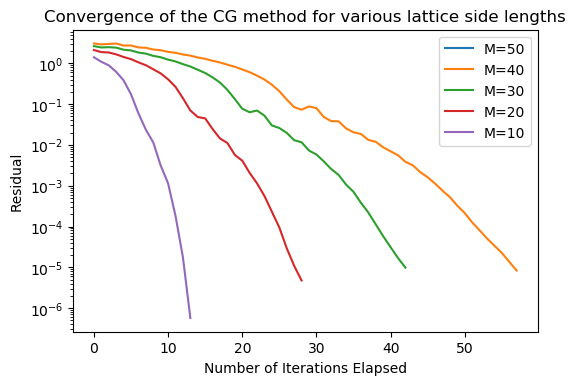

In [18]:
# This cell sets up an algorithm to exctract the estimated
# vector at each iteration of the CG method. This vector is
# used caclulate the residual, which is then plotted accoding
# the iteration number.
def measure_convergence(LOP, N):
    """
    For each iterate, measure and record the residual.
    """
    b = np.ones(N**2)
    record = []
    def residual(u):
        """
        Calculate the residual.
        """
        residual = np.linalg.norm(b-LOP.matvec(u), 2)/np.linalg.norm(b)
        record.append(residual)
    # Execute solve and return results
    usol, info = cg(LOP, b, callback=residual)    
    return usol, record


def multi_N_convergence(N_list):
    """
    Solves the problem and measures convergence
    for each problem of size given in the list.
    """
    multi_residuals = []
    muti_iterates = []
    for N in N_list:
        CGLop = FivePointStencil(N)
        _, residuals = measure_convergence(CGLop, N)
        iterates = [i for i, _ in enumerate(residuals)]
        multi_residuals.append(residuals)
        muti_iterates.append(iterates)
    return muti_iterates, multi_residuals

# Set the list of matrix sizes
N_list = np.array([50, 40, 30, 20, 10])
# Run the convergence measurements
iterations, residuals_list = multi_N_convergence(N_list)
# Plot results.
for N, iterates, residuals in zip(N_list, iterations, residuals_list):
    plt.semilogy(iterates, residuals, label='M=%i'%N)
    plt.xlabel('Number of Iterations Elapsed')
    plt.ylabel('Residual')
    plt.title('Convergence of the CG method for various lattice side lengths')
    plt.legend()
fig = plt.gcf()
fig.set_dpi(100)
plt.show()

In the above graph, it appears that the CG method converges more slowly for larger values of $M$. We also note that the final approximatoin is also much more accurate for small values of $M$. Beyond smaller values, however, the differnence in error becomes negligible.

### Impact of Lattice Size on Number of Iterations

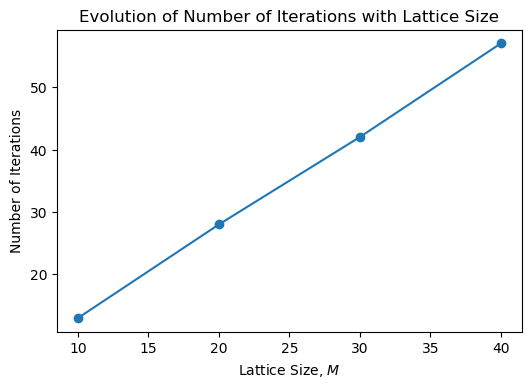

In [24]:
# This cell extracts the number of iterations that
# happened for each lattice size in the cell above.
# The number of iterations is plotted against the
# lattice size.
iter_count = [iterates[-1] for iterates in iterations]
i = [i for i, value in enumerate(iter_count) if value < 8000]
plt.plot(np.array(N_list)[i], np.array(iter_count)[i], '-o')
plt.xlabel('Lattice Size, $M$')
plt.ylabel('Number of Iterations')
plt.title('Evolution of Number of Iterations with Lattice Size')
fig = plt.gcf()
fig.set_dpi(100)
plt.show()

It is evident here that there is a strongly linear
relationship between the number of iterations required
for a solution and the size of the lattice, $M$.

### Display of the Solution

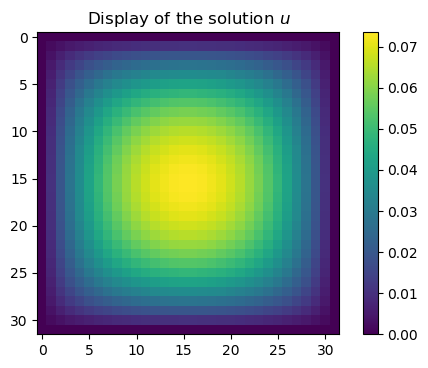

In [27]:
def format_shape(sol, N):
    """
    Formats the solution vector back into
    the original shape and adding in the 
    boundary conditions.
    """
    # The inner square does not have the 1st or
    # last value
    shaped = sol.reshape((N, N))
    # Return the reshaped array with 0's around it
    # corresponding to the BC's
    return np.pad(shaped, 1, mode='constant')


def show_square(N):
    """
    Solve and plot a colour image of the solution.
    """
    LOP = FivePointStencil(N)
    sol, info_lop = cg(LOP, np.ones(N**2))
    plt.imshow(format_shape(sol, N))
    plt.colorbar()
    plt.title('Display of the solution $u$')
    fig = plt.gcf()
    fig.set_dpi(100)
    plt.show()

# Make the shape
N = 30
show_square(N)